18.2 seconds


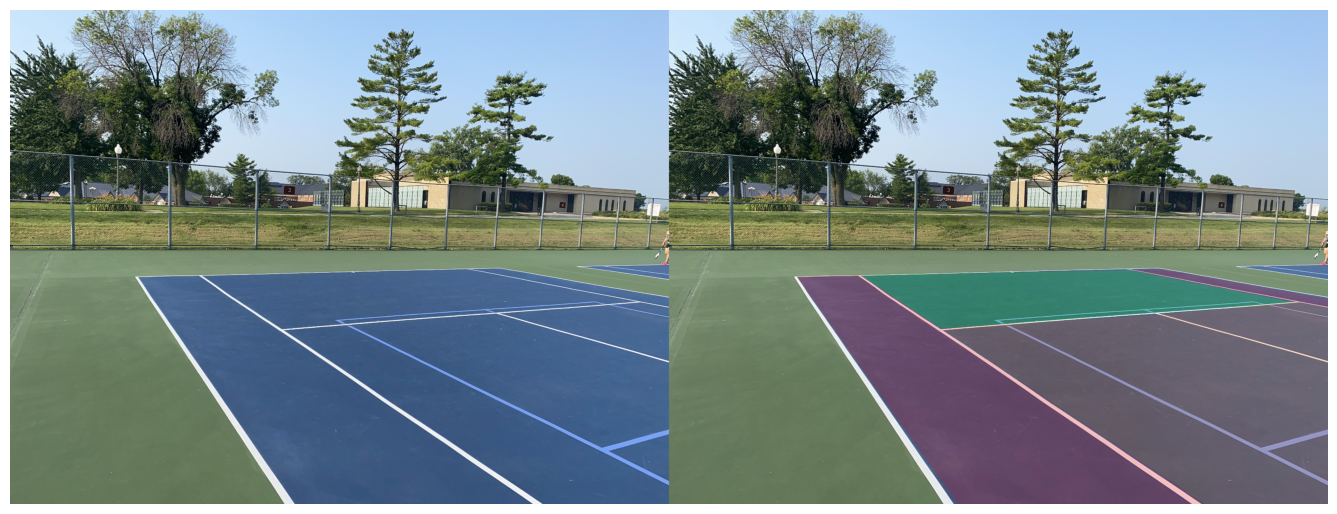

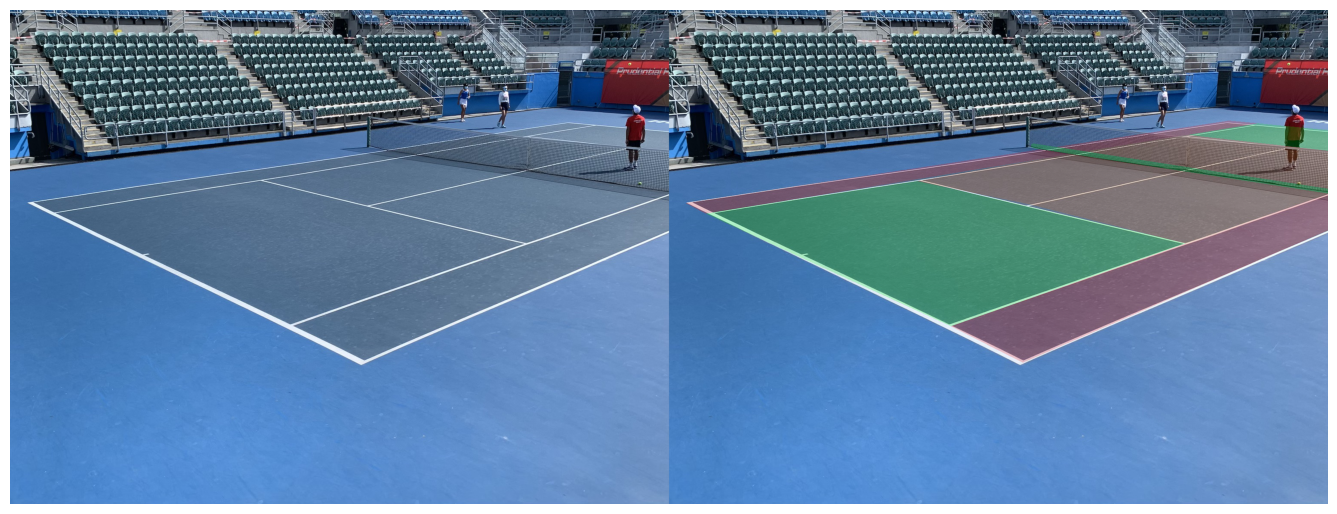

<Figure size 1700x700 with 0 Axes>

In [1]:
import os
import cv2
import time
import threading
import numpy as np
from matplotlib import pyplot as plt
from homography_detection import find_homographies
        
image_folder = 'tennis_court_images'

alpha = .8
new_image_height = 1149
canny_threshold1_end = 319
canny_threshold1_start = 278

start_time = time.time()
plt.rcParams['figure.figsize'] = 17, 7

for image in os.listdir(image_folder):
    valid_homographies = []
    bgr_image = cv2.imread(image_folder+'/'+image)
    image_height, image_width, _ = bgr_image.shape
    rescale_factor = image_height/new_image_height
    resized_bgr = cv2.resize(bgr_image, (int(image_width/rescale_factor), int(image_height/rescale_factor)))
    rgb = cv2.cvtColor(resized_bgr, cv2.COLOR_BGR2RGB)
    detection_image = rgb.copy()
    gray = cv2.cvtColor(resized_bgr, cv2.COLOR_BGR2GRAY)
    ts = [threading.Thread(target=find_homographies, args=(gray, canny_threshold1, valid_homographies)) for canny_threshold1 in range(canny_threshold1_start, canny_threshold1_end)]
    [t.start() for t in ts]
    [t.join() for t in ts]

    if (valid_homographies):
        detected_and_predicted = min(valid_homographies, key=lambda valid_homography:valid_homography['homography_error'])['detected_and_predicted']

        for back_rectangle in [[1, 2, 6, 4], [14, 16, 19, 18]]:
            back_rectangle_coordinates = np.array([detected_and_predicted[back_rectangle_index] for back_rectangle_index in back_rectangle])

            if all(coordinate > 0 for coordinate in back_rectangle_coordinates.flatten()):
                cv2.fillPoly(detection_image, [back_rectangle_coordinates], (0, 255, 0))

        for lane in [[0, 1, 9, 8], [8, 9, 18, 17], [2, 3, 12, 11], [11, 12, 20, 19]]:
            lane_coordinates = np.array([detected_and_predicted[lane_index] for lane_index in lane])

            if all(coordinate > 0 for coordinate in lane_coordinates.flatten()):
                cv2.fillPoly(detection_image, [lane_coordinates], (255, 0, 0))

        for front_squares in [[4, 5, 10, 9], [9, 10, 15, 14], [5, 6, 11, 10], [10, 11, 16, 15]]:
            front_square_coordinates = np.array([detected_and_predicted[front_square_index] for front_square_index in front_squares])

            if all(coordinate > 0 for coordinate in front_square_coordinates.flatten()):
                cv2.fillPoly(detection_image, [front_square_coordinates], (255, 100, 0))

        cv2.line(detection_image, (detected_and_predicted[7][0], detected_and_predicted[7][1]), (detected_and_predicted[13][0], detected_and_predicted[13][1]), (0, 255, 0), 10)
        plt.axis('off')
        plt.imshow(np.concatenate((rgb, cv2.addWeighted(rgb, alpha, detection_image, 1-alpha, 0)), axis=1))
        plt.figure()

print(str(round(time.time() - start_time, 2)) + " seconds")
